# Music Genre Classification

## 5. AutoML for Images

<img src='music.jpg' width = 600>

<div class="alert alert-info"> <b> In this notebook we will build, train and deploy an images classification model using AutoML for Images on the spectograms images.</b></div>

Serge Retkowsky | serge.retkowsky@microsoft.com | 02-Mar-2022 | V1

## What is AutoML for Images?

<img src="https://github.com/retkowsky/AutoMLforImages/blob/main/images/AutoML%20for%20Images.png?raw=true" width=700>

- Setup AutoML for Images:
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models
- Documentation:
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#model-specific-hyperparameters
- Supported Algorithms:
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#supported-model-algorithms

## 1. Informations

In [1]:
import numpy as np
import json
import os
import urllib
from zipfile import ZipFile
import pandas as pd
import time

In [2]:
import sys
print("Python version =", sys.version)

Python version = 3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]


In [3]:
# Your local platform
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['Platform']=platform.system()
        info['Platform-release']=platform.release()
        info['Platform-version']=platform.version()
        info['Architecture']=platform.machine()
        info['Hostname']=socket.gethostname()
        info['IP-address']=socket.gethostbyname(socket.gethostname())
        info['MAC-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['Processor']=platform.processor()
        info['RAM']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" Go"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'Platform': 'Linux',
 'Platform-release': '5.4.0-1056-azure',
 'Platform-version': '#58~18.04.1-Ubuntu SMP Wed Jul 28 23:14:18 UTC 2021',
 'Architecture': 'x86_64',
 'Hostname': 'seretkow9',
 'IP-address': '127.0.0.1',
 'MAC-address': '00:0d:3a:bb:38:dc',
 'Processor': 'x86_64',
 'RAM': '14 Go'}

In [4]:
def filedir(LOCALFILE):
    timefile1 = os.path.getmtime(LOCALFILE)
    timefile = time.ctime(timefile1)
    timefile = time.strptime(timefile)
    timestamp = time.strftime("%Y-%m-%d %H:%M:%S", timefile)
    file_size = os.path.getsize(LOCALFILE)
    file_size_mb = str(round(file_size/1024**2, 2))
    print(LOCALFILE, '|', timestamp, '|', file_size_mb, 'Mb')

In [5]:
import azureml.core
print("You are using Azure ML version", azureml.core.VERSION)

You are using Azure ML version 1.35.0


## 2. Workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

> Create an Azure ML Workspace within your Azure subscription, or load an existing workspace.

In [6]:
subscription_id = os.environ.get("SUBSCRIPTION_ID", "tobereplaced")
resource_group = os.environ.get("RESOURCE_GROUP", "azuremlvision-rg")
workspace_name = os.environ.get("WORKSPACE_NAME", "azuremlvision")

In [7]:
from azureml.core import Workspace
try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    ws.write_config()
    print("OK")
except:
    print("Error: Workspace not found")

OK


In [8]:
from azureml.core import Workspace
ws = Workspace.from_config()

In [9]:
ws.name, ws.resource_group

('azuremlvision', 'azuremlvision-rg')

## 3. Azure ML GPU Compute target setup
**You will need to provide a [Compute Target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) that will be used for your AutoML model training.** <br><br>
**AutoML models for image tasks require GPU SKUs and support NC and ND families.** We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [10]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "AutoML-GPU"

try:
    compute_target = ws.compute_targets[cluster_name]
    print('Found existing compute target.')
except KeyError:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6', # GPU cluster
                                                           idle_seconds_before_scaledown=1800, # Time out
                                                           min_nodes=0, 
                                                           max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Creating a new compute target...
InProgress.
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [11]:
# Compute status
compute_target.provisioning_state

'Succeeded'

In [12]:
# Compute cluster information
compute_target.get_status().serialize()

{'currentNodeCount': 0,
 'targetNodeCount': 0,
 'nodeStateCounts': {'preparingNodeCount': 0,
  'runningNodeCount': 0,
  'idleNodeCount': 0,
  'unusableNodeCount': 0,
  'leavingNodeCount': 0,
  'preemptedNodeCount': 0},
 'allocationState': 'Resizing',
 'allocationStateTransitionTime': '2022-03-21T09:21:21.269000+00:00',
 'errors': None,
 'creationTime': '2022-03-21T09:21:20.779642+00:00',
 'modifiedTime': '2022-03-21T09:21:24.445583+00:00',
 'provisioningState': 'Succeeded',
 'provisioningStateTransitionTime': None,
 'scaleSettings': {'minNodeCount': 0,
  'maxNodeCount': 4,
  'nodeIdleTimeBeforeScaleDown': 'PT1800S'},
 'vmPriority': 'Dedicated',
 'vmSize': 'STANDARD_NC6'}

In [13]:
# Compute VM size
compute_target.vm_size

'STANDARD_NC6'

## 4. Experiment Setup
Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) in your workspace to track your model training runs

In [15]:
from azureml.core import Experiment

experiment_name = 'AutoMLImages-MusicGenreClassification' #Name of your experimentation
experiment = Experiment(ws, name=experiment_name)

In [16]:
experiment

Name,Workspace,Report Page,Docs Page
AutoMLImages-MusicGenreClassification,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


## 5. Dataset with input Training Data
In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an AzureML Labeled Dataset. You can either use a Labeled Dataset that you have exported from a Data Labeling project, or create a new Labeled Dataset with your labeled training data

In [17]:
os.chdir('spectogramsmusicgenres')

In [18]:
# We have some images for the tags in directories we want to detect
print(os.listdir('.'))

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock', 'train_annotations.jsonl', 'validation_annotations.jsonl']


In [19]:
for root, _, files in os.walk('.'):
    print("Dir:", root, " = ", len(files), "images files.")

Dir: .  =  2 images files.
Dir: ./blues  =  100 images files.
Dir: ./classical  =  100 images files.
Dir: ./country  =  100 images files.
Dir: ./disco  =  100 images files.
Dir: ./hiphop  =  100 images files.
Dir: ./jazz  =  100 images files.
Dir: ./metal  =  100 images files.
Dir: ./pop  =  100 images files.
Dir: ./reggae  =  100 images files.
Dir: ./rock  =  100 images files.


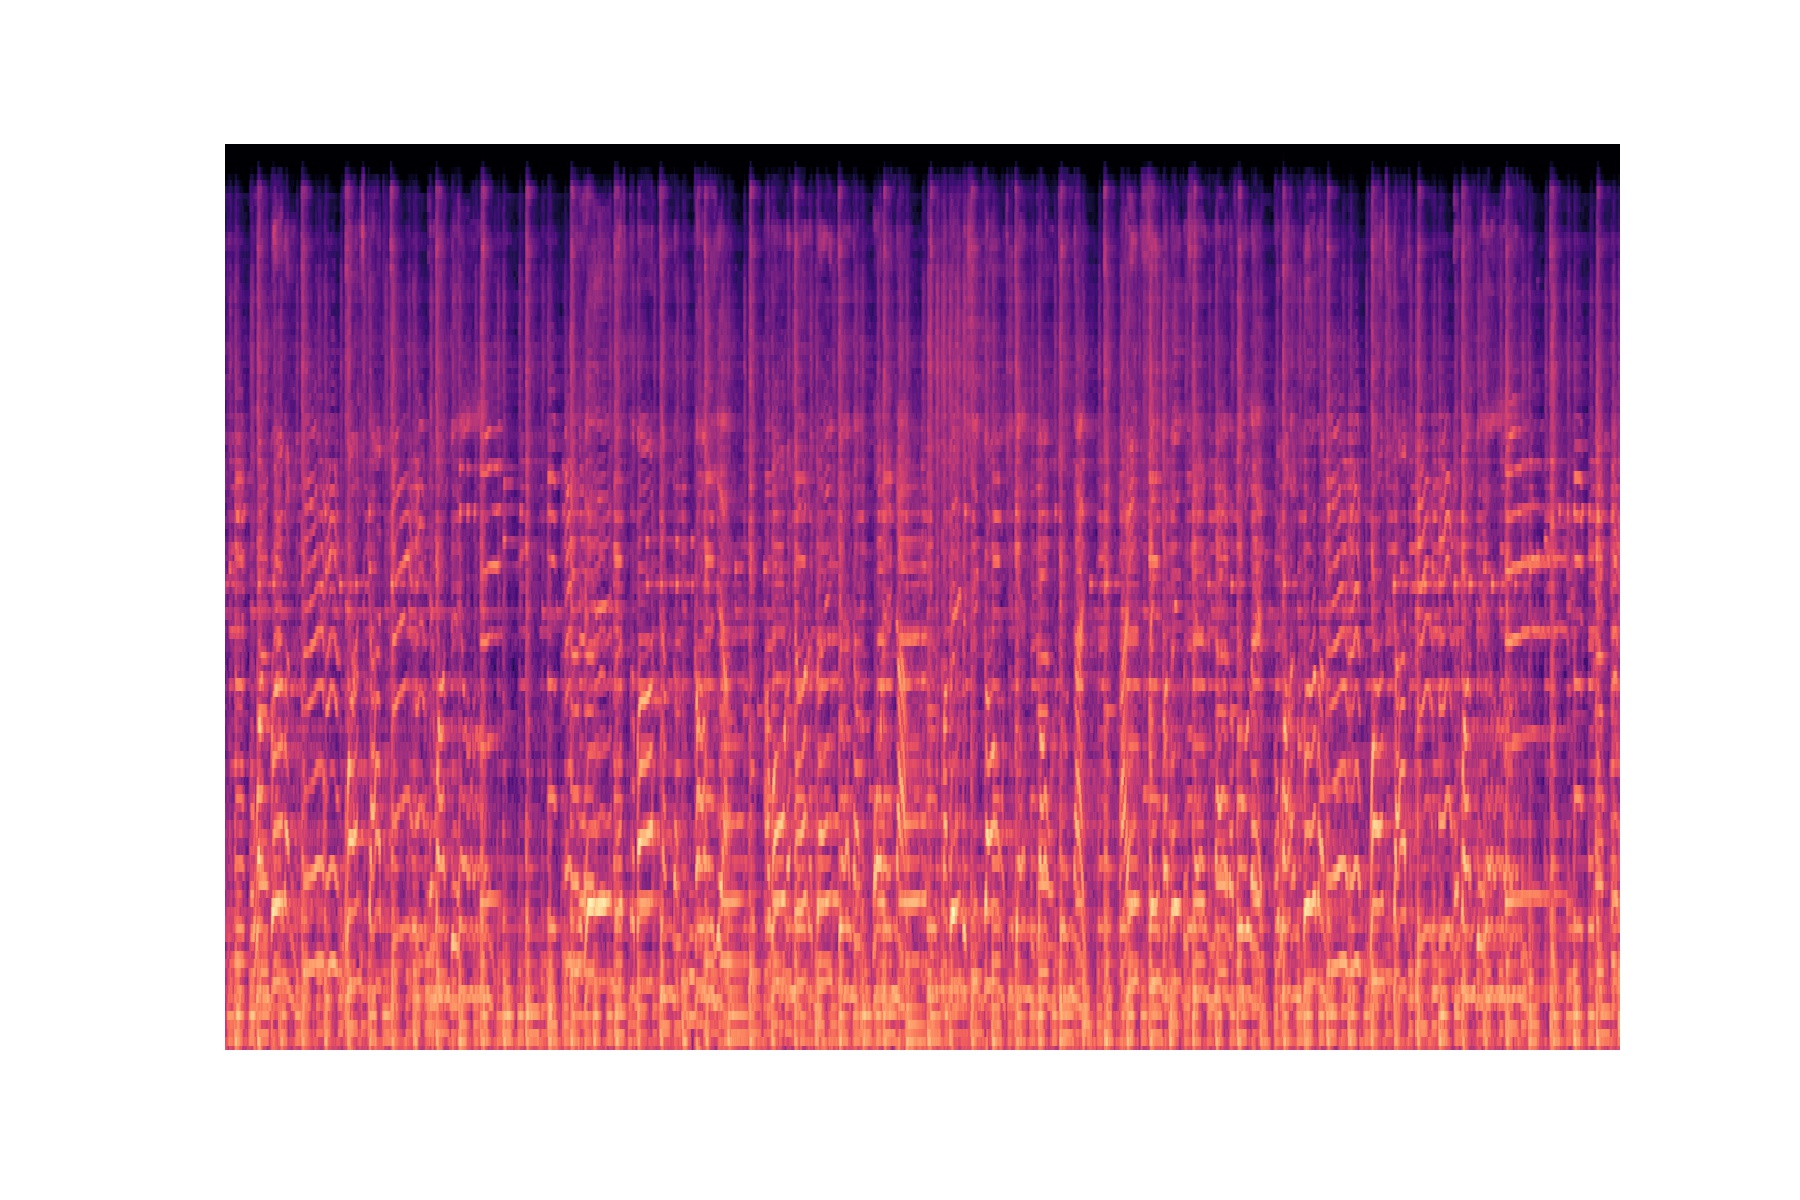

In [20]:
from IPython.display import Image
sample_image = 'blues/blues.00000.jpg'
Image(filename=sample_image) 

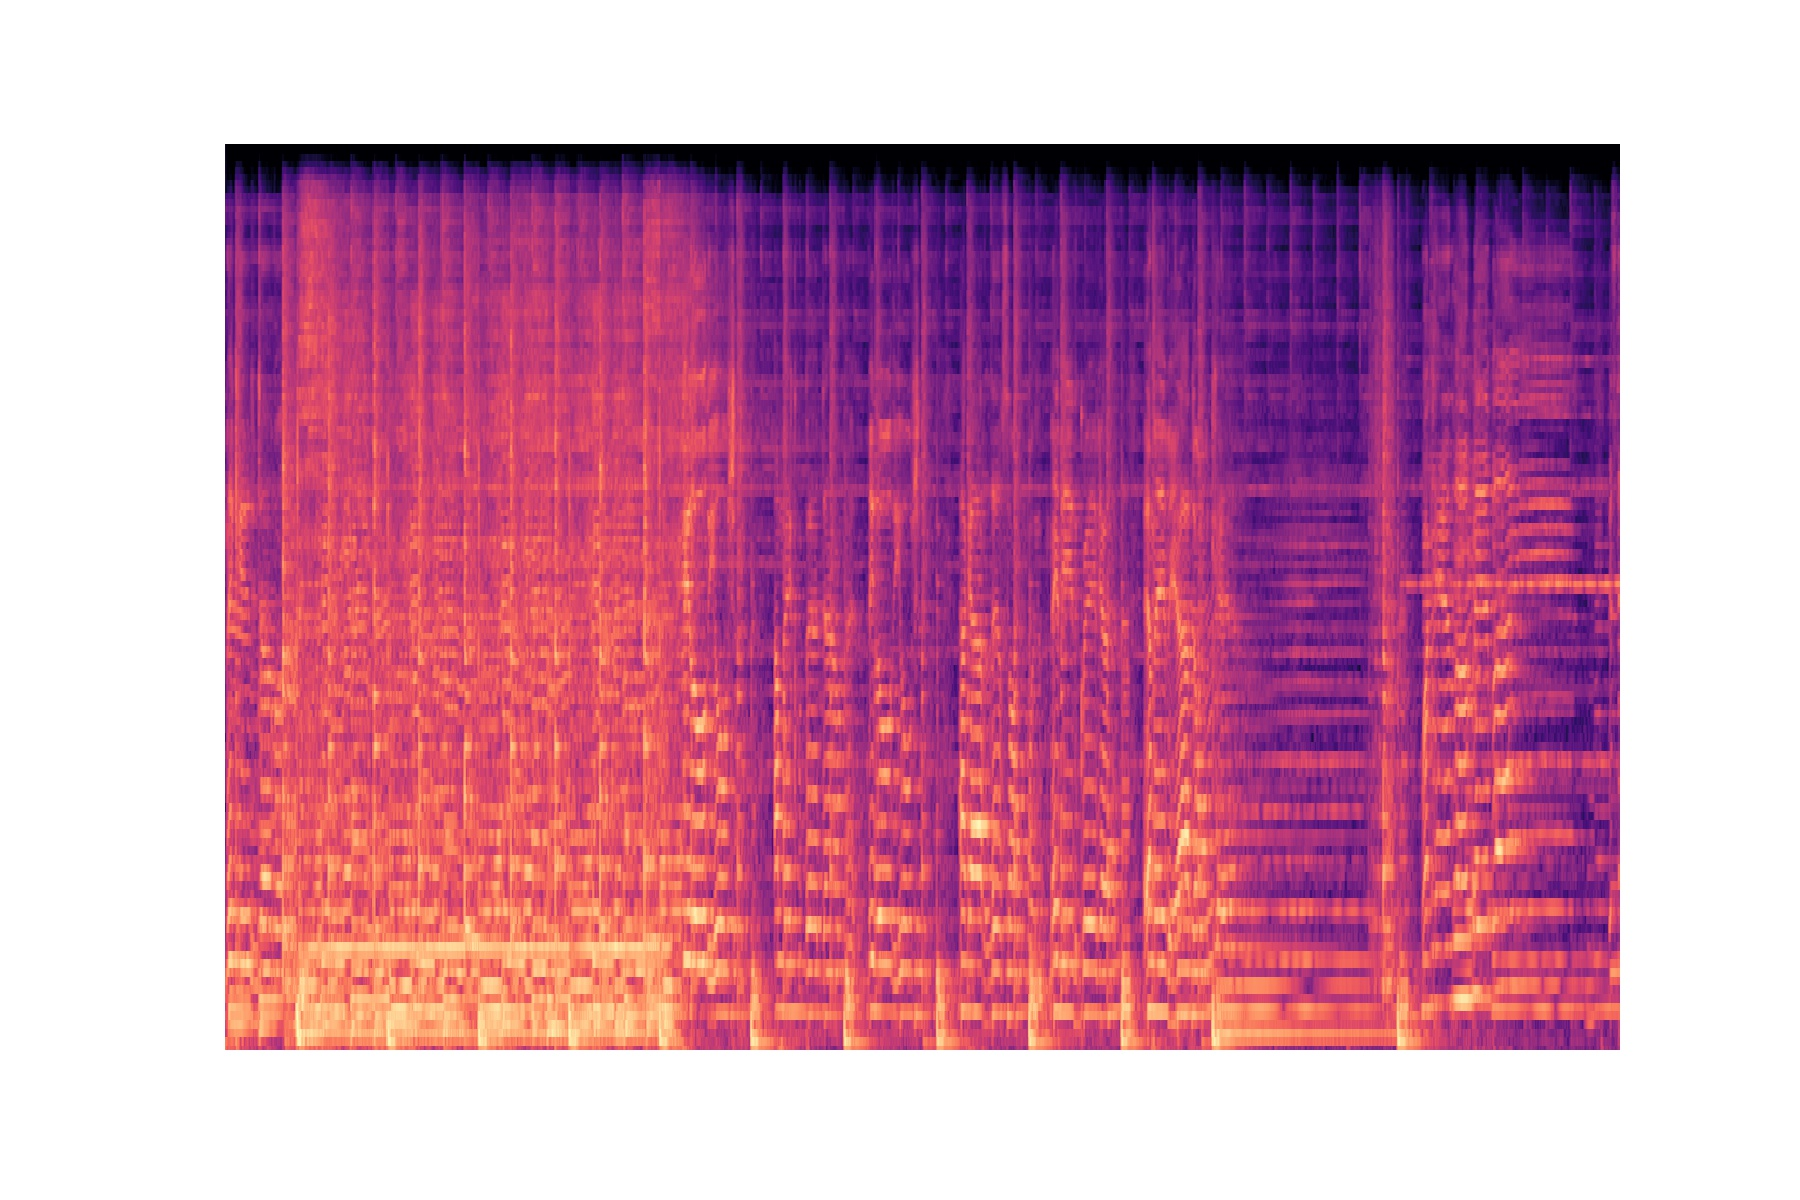

In [21]:
from IPython.display import Image
sample_image = 'rock/rock.00000.jpg'
Image(filename=sample_image) 

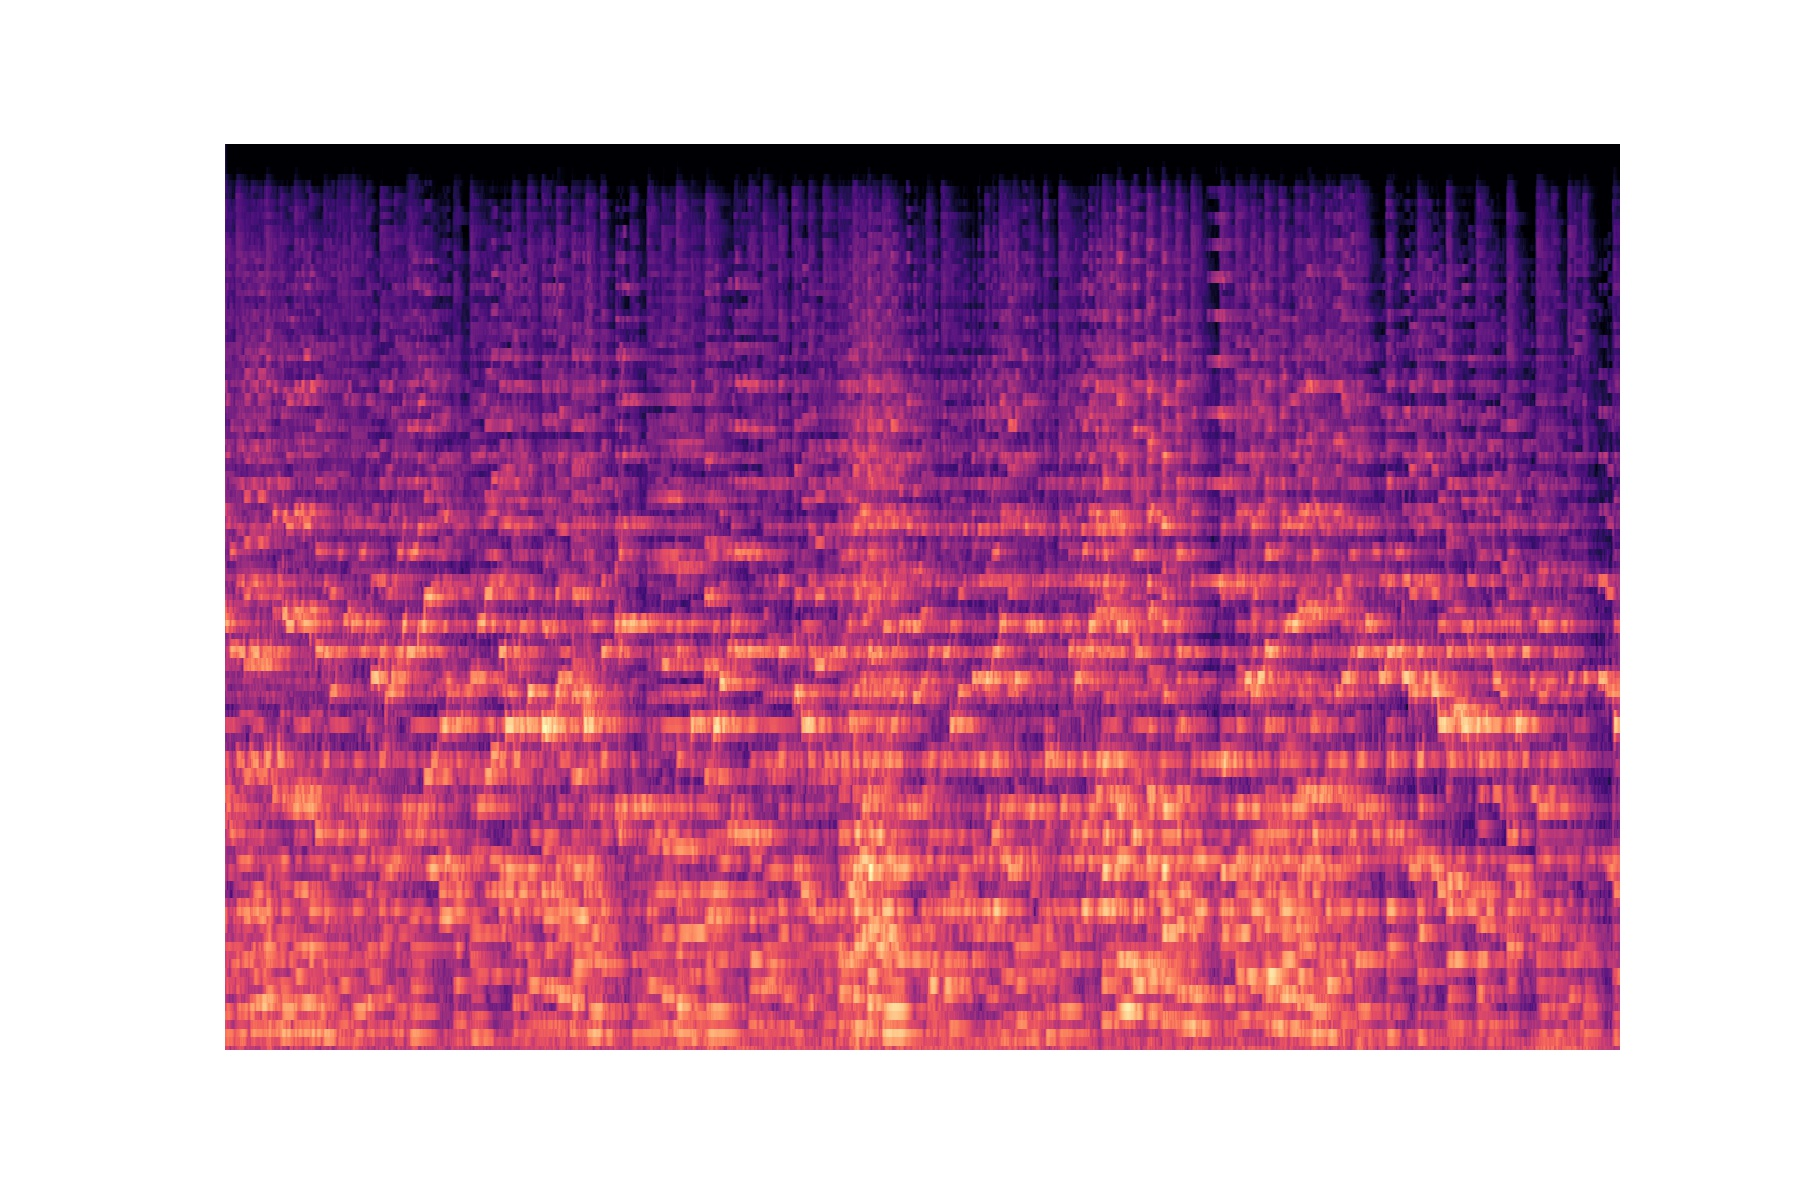

In [22]:
from IPython.display import Image
sample_image = 'classical/classical.00000.jpg'
Image(filename=sample_image) 

### Convert the downloaded data to JSONL


In [23]:
os.chdir('..')

In [24]:
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/Sound/MusicGenreClassification'

In [25]:
src = "spectogramsmusicgenres/"

train_validation_ratio = 5

# Retrieving default datastore that got automatically created when we setup a workspace
workspaceblobstore = ws.get_default_datastore().name

# Path to the training and validation files
train_annotations_file = os.path.join(src, "train_annotations.jsonl")
validation_annotations_file = os.path.join(src, "validation_annotations.jsonl")

# sample json line dictionary
json_line_sample = \
    {
        "image_url": "AmlDatastore://" + workspaceblobstore + "/"
                     + os.path.basename(os.path.dirname(src)),
        "label": "",
        "label_confidence": 1.0
    }

index = 0
# Scan each sub directary and generate jsonl line
with open(train_annotations_file, 'w') as train_f:
    with open(validation_annotations_file, 'w') as validation_f:
        for className in os.listdir(src):
            subDir = src + className
            if not os.path.isdir(subDir):
                continue
            # Scan each sub directary
            print("Parsing " + subDir)
            for image in os.listdir(subDir):
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"/{className}/{image}"
                json_line["label"] = className

                if index % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")
                index += 1

Parsing spectogramsmusicgenres/blues
Parsing spectogramsmusicgenres/classical
Parsing spectogramsmusicgenres/country
Parsing spectogramsmusicgenres/disco
Parsing spectogramsmusicgenres/hiphop
Parsing spectogramsmusicgenres/jazz
Parsing spectogramsmusicgenres/metal
Parsing spectogramsmusicgenres/pop
Parsing spectogramsmusicgenres/reggae
Parsing spectogramsmusicgenres/rock


### Upload the JSONL file and images to Datastore  
In order to use the data for training in Azure ML, we upload it to our Azure ML Workspace via a [Datastore](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores). The datastore provides a mechanism for you to upload/download data, and interact with it from your remote compute targets. It is an abstraction over Azure Storage.



In [26]:
# Retrieving default datastore that got automatically created when we setup a workspace
ds = ws.get_default_datastore()
ds.upload(src_dir='./spectogramsmusicgenres/', target_path='spectogramsmusicgenres')

Uploading an estimated of 1002 files
Target already exists. Skipping upload for spectogramsmusicgenres/train_annotations.jsonl
Target already exists. Skipping upload for spectogramsmusicgenres/validation_annotations.jsonl
Target already exists. Skipping upload for spectogramsmusicgenres/blues/blues.00000.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/blues/blues.00001.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/blues/blues.00002.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/blues/blues.00003.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/blues/blues.00004.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/blues/blues.00005.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/blues/blues.00006.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/blues/blues.00007.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/blues/bl

Target already exists. Skipping upload for spectogramsmusicgenres/classical/classical.00024.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/classical/classical.00025.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/classical/classical.00026.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/classical/classical.00027.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/classical/classical.00028.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/classical/classical.00029.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/classical/classical.00030.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/classical/classical.00031.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/classical/classical.00032.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/classical/classical.00033.jpg
Target already exists. Skipping upload f

Target already exists. Skipping upload for spectogramsmusicgenres/country/country.00028.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/country/country.00029.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/country/country.00030.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/country/country.00031.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/country/country.00032.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/country/country.00033.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/country/country.00034.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/country/country.00035.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/country/country.00036.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/country/country.00037.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/country/countr

Target already exists. Skipping upload for spectogramsmusicgenres/disco/disco.00034.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/disco/disco.00035.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/disco/disco.00036.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/disco/disco.00037.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/disco/disco.00038.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/disco/disco.00039.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/disco/disco.00040.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/disco/disco.00041.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/disco/disco.00042.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/disco/disco.00043.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/disco/disco.00044.jpg
Target already exists. Skipping 

Target already exists. Skipping upload for spectogramsmusicgenres/hiphop/hiphop.00035.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/hiphop/hiphop.00036.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/hiphop/hiphop.00037.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/hiphop/hiphop.00038.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/hiphop/hiphop.00039.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/hiphop/hiphop.00040.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/hiphop/hiphop.00041.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/hiphop/hiphop.00042.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/hiphop/hiphop.00043.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/hiphop/hiphop.00044.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/hiphop/hiphop.00045.jpg
Target alr

Target already exists. Skipping upload for spectogramsmusicgenres/jazz/jazz.00035.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/jazz/jazz.00036.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/jazz/jazz.00037.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/jazz/jazz.00038.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/jazz/jazz.00039.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/jazz/jazz.00040.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/jazz/jazz.00041.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/jazz/jazz.00042.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/jazz/jazz.00043.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/jazz/jazz.00044.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/jazz/jazz.00045.jpg
Target already exists. Skipping upload for spectograms

Target already exists. Skipping upload for spectogramsmusicgenres/metal/metal.00038.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/metal/metal.00039.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/metal/metal.00040.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/metal/metal.00041.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/metal/metal.00042.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/metal/metal.00043.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/metal/metal.00044.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/metal/metal.00045.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/metal/metal.00046.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/metal/metal.00047.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/metal/metal.00048.jpg
Target already exists. Skipping 

Target already exists. Skipping upload for spectogramsmusicgenres/pop/pop.00036.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/pop/pop.00037.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/pop/pop.00038.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/pop/pop.00039.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/pop/pop.00040.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/pop/pop.00041.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/pop/pop.00042.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/pop/pop.00043.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/pop/pop.00044.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/pop/pop.00045.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/pop/pop.00046.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/pop/pop.00

Target already exists. Skipping upload for spectogramsmusicgenres/reggae/reggae.00037.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/reggae/reggae.00038.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/reggae/reggae.00039.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/reggae/reggae.00040.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/reggae/reggae.00041.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/reggae/reggae.00042.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/reggae/reggae.00043.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/reggae/reggae.00044.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/reggae/reggae.00045.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/reggae/reggae.00046.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/reggae/reggae.00047.jpg
Target alr

Target already exists. Skipping upload for spectogramsmusicgenres/rock/rock.00062.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/rock/rock.00063.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/rock/rock.00064.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/rock/rock.00065.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/rock/rock.00066.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/rock/rock.00067.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/rock/rock.00068.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/rock/rock.00069.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/rock/rock.00070.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/rock/rock.00071.jpg
Target already exists. Skipping upload for spectogramsmusicgenres/rock/rock.00072.jpg
Target already exists. Skipping upload for spectograms

$AZUREML_DATAREFERENCE_236d2e04513b4c598f693e7ac6cbcc1a

In [27]:
ds

{
  "name": "workspaceblobstore",
  "container_name": "azureml-blobstore-c3c87d4d-5b7e-436b-8a1a-5765a35e9878",
  "account_name": "azuremlvision8724517013",
  "protocol": "https",
  "endpoint": "core.windows.net"
}

Finally, we need to create an Azure ML [Dataset](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores) from the data we uploaded to the Datastore. We create one dataset for training and one for validation.

In [28]:
from azureml.contrib.dataset.labeled_dataset import _LabeledDatasetFactory, LabeledDatasetTask
from azureml.core import Dataset

training_dataset_name = 'musicgenreTrainingDataset'

if training_dataset_name in ws.datasets:
    training_dataset = ws.datasets.get(training_dataset_name)
    print('Found the training dataset', training_dataset_name)

else:
    # create training dataset
    training_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.IMAGE_CLASSIFICATION, path=ds.path('spectogramsmusicgenres/train_annotations.jsonl'))
    training_dataset = training_dataset.register(workspace=ws, name=training_dataset_name)
    
# create validation dataset
validation_dataset_name = "musicgenreValidationDataset"

if validation_dataset_name in ws.datasets:
    validation_dataset = ws.datasets.get(validation_dataset_name)
    print('Found the validation dataset', validation_dataset_name)

else:
    validation_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.IMAGE_CLASSIFICATION, path=ds.path('spectogramsmusicgenres/validation_annotations.jsonl'))
    validation_dataset = validation_dataset.register(workspace=ws, name=validation_dataset_name)

print("\nTraining dataset name:" + training_dataset.name)
print("Validation dataset name:" + validation_dataset.name)

Found the training dataset musicgenreTrainingDataset
Found the validation dataset musicgenreValidationDataset

Training dataset name:musicgenreTrainingDataset
Validation dataset name:musicgenreValidationDataset


Validation dataset is optional. If no validation dataset is specified, by default 20% of your training data will be used for validation. You can control the percentage using the `split_ratio` argument - please refer to the documentation for more details.

This is what the training dataset looks like

In [29]:
images=training_dataset.to_pandas_dataframe()

In [30]:
images.shape

(800, 3)

In [31]:
images.head()

,image_url,label,label_confidence
0,StreamInfo(AmlDatastore://spectogramsmusicgenr...,blues,1.0
1,StreamInfo(AmlDatastore://spectogramsmusicgenr...,blues,1.0
2,StreamInfo(AmlDatastore://spectogramsmusicgenr...,blues,1.0
3,StreamInfo(AmlDatastore://spectogramsmusicgenr...,blues,1.0
4,StreamInfo(AmlDatastore://spectogramsmusicgenr...,blues,1.0


In [32]:
images['label'].value_counts()

disco        80
classical    80
blues        80
jazz         80
pop          80
reggae       80
rock         80
metal        80
country      80
hiphop       80
Name: label, dtype: int64

In [33]:
# Percentage values
images['label'].value_counts(normalize=True)

disco        0.1
classical    0.1
blues        0.1
jazz         0.1
pop          0.1
reggae       0.1
rock         0.1
metal        0.1
country      0.1
hiphop       0.1
Name: label, dtype: float64

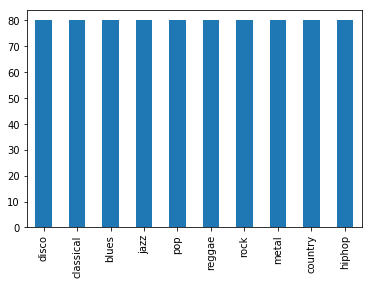

In [34]:
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt
images['label'].value_counts(sort=True).plot.bar()

## 6. Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML runs for image related tasks are specified using the 'AutoMLImageConfig' - please refer to the [documentation](https://github.com/swatig007/automlForImages#readme) for the details on the parameters that can be used and their values. 

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple ones.<br><br> 

### Using default hyperparameter values for the specified algorithm

Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This is for employing a more iterative approach, because with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially and you need more iterations to find optimal configurations.


Supported Algorithms
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#supported-model-algorithms

In [35]:
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import RandomParameterSampling
from azureml.train.hyperdrive import GridParameterSampling
from azureml.train.hyperdrive import choice
from azureml.automl.core.shared.constants import ImageTask

In [36]:
# AutoML Configuration
image_config = AutoMLImageConfig(task=ImageTask.IMAGE_CLASSIFICATION, # AutoML Vision task
                                 compute_target=compute_target, # Compute target
                                 training_data=training_dataset, # Training dataset
                                 validation_data=validation_dataset, # Validation dataset
                                 hyperparameter_sampling=GridParameterSampling({'model_name': choice('seresnext')}),
                                 iterations=1)

## 7. Submitting an AutoML run for Computer Vision tasks 
Once you've created the config settings for your run, **you can submit an AutoML run** using the config in order to train a vision model using your training dataset.

In [37]:
automl_image_run = experiment.submit(image_config)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
AutoMLImages-MusicGenreClassification,AutoML_d54a7fe2-b0ca-4bea-a93c-968e9aa1e5f0,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [38]:
automl_image_run.wait_for_completion(wait_post_processing=True) # Wait until automl run is finished

{'runId': 'AutoML_d54a7fe2-b0ca-4bea-a93c-968e9aa1e5f0',
 'target': 'AutoML-GPU',
 'status': 'Completed',
 'startTimeUtc': '2022-03-21T09:22:43.012902Z',
 'endTimeUtc': '2022-03-21T09:44:14.925076Z',
 'services': {},
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'AutoML-GPU',
  'AMLSettingsJsonString': '{"path":null,"name":"AutoMLImages-MusicGenreClassification","subscription_id":"70b8f39e-8863-49f7-b6ba-34a80799550c","resource_group":"azuremlvision-rg","workspace_name":"azuremlvision","region":"westeurope","compute_target":"AutoML-GPU","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":true,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1,"primary_metric":

In [39]:
automl_image_run.id

'AutoML_d54a7fe2-b0ca-4bea-a93c-968e9aa1e5f0'

In [40]:
experiment

Name,Workspace,Report Page,Docs Page
AutoMLImages-MusicGenreClassification,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


In [41]:
best_child_run=automl_image_run.get_best_child()
best_child_run.download_file("confusion_matrix", output_file_path = "confusion_matrix_automl1.json")

In [48]:
# List of all the AutoML for Images metrics values
automlvisionmetrics = automl_image_run.get_metrics()
automlvisionmetrics

{'recall_score_macro': [0.245,
  0.51,
  0.56,
  0.615,
  0.55,
  0.66,
  0.69,
  0.66,
  0.705,
  0.735,
  0.75,
  0.745,
  0.765,
  0.795,
  0.78],
 'precision_score_micro': [0.245,
  0.51,
  0.56,
  0.615,
  0.55,
  0.66,
  0.69,
  0.66,
  0.705,
  0.735,
  0.75,
  0.745,
  0.765,
  0.795,
  0.78],
 'precision_score_weighted': [0.25713,
  0.49783,
  0.58417,
  0.67141,
  0.5801,
  0.73201,
  0.70403,
  0.66258,
  0.71804,
  0.74086,
  0.8158,
  0.74234,
  0.7739,
  0.80136,
  0.77856],
 'AUC_micro': [0.66631,
  0.85848,
  0.91255,
  0.92438,
  0.88329,
  0.94381,
  0.95724,
  0.94906,
  0.96374,
  0.96682,
  0.96309,
  0.96733,
  0.96906,
  0.97045,
  0.97106],
 'recall_score_micro': [0.245,
  0.51,
  0.56,
  0.615,
  0.55,
  0.66,
  0.69,
  0.66,
  0.705,
  0.735,
  0.75,
  0.745,
  0.765,
  0.795,
  0.78],
 'average_precision_score_weighted': [0.31939,
  0.5673,
  0.67624,
  0.71253,
  0.62184,
  0.78855,
  0.78837,
  0.74899,
  0.78764,
  0.8206,
  0.81644,
  0.82015,
  0.8399,
 

In [49]:
automlvisionmetrics['classification_report']

{'class_name': ['blues',
  'classical',
  'country',
  'disco',
  'hiphop',
  'jazz',
  'metal',
  'pop',
  'reggae',
  'rock',
  'micro avg',
  'macro avg',
  'weighted avg'],
 'precision': [0.80952,
  0.95238,
  0.61905,
  0.64286,
  0.89474,
  0.9,
  1.0,
  0.84211,
  0.70588,
  0.64706,
  0.795,
  0.80136,
  0.80136],
 'recall': [0.85,
  1.0,
  0.65,
  0.9,
  0.85,
  0.9,
  0.85,
  0.8,
  0.6,
  0.55,
  0.795,
  0.795,
  0.795],
 'f1-score': [0.82927,
  0.97561,
  0.63415,
  0.75,
  0.87179,
  0.9,
  0.91892,
  0.82051,
  0.64865,
  0.59459,
  0.795,
  0.79435,
  0.79435],
 'support': [20.0,
  20.0,
  20.0,
  20.0,
  20.0,
  20.0,
  20.0,
  20.0,
  20.0,
  20.0,
  200.0,
  200.0,
  200.0],
 'auc': [0.98778,
  0.99972,
  0.94167,
  0.97333,
  0.9425,
  0.99556,
  0.99528,
  0.98472,
  0.94667,
  0.88694,
  0.97045,
  0.96542,
  0.96542],
 'average_precision': [0.9239,
  0.99762,
  0.64213,
  0.82268,
  0.84596,
  0.97102,
  0.96643,
  0.84427,
  0.79883,
  0.59634,
  0.85734,
  0.84

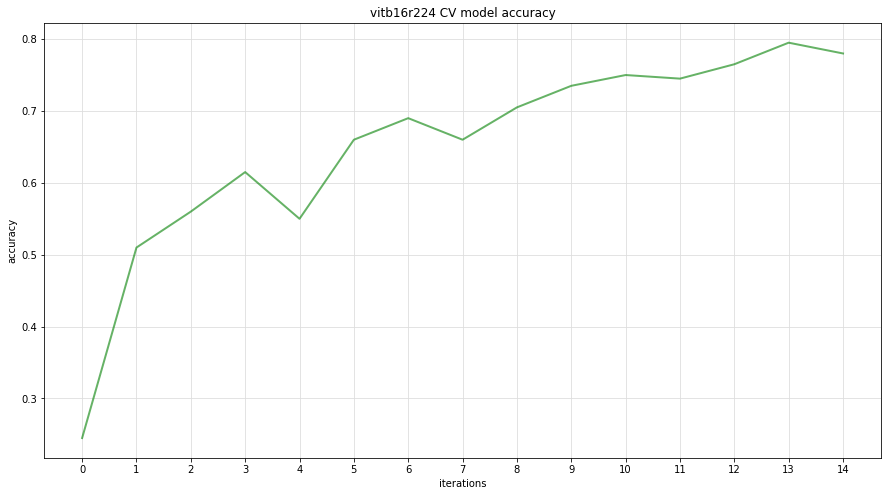

In [53]:
# Let's plot the accuracy metric for the CV model, save the graph to a jpg file and log it to the Azure ML experiment
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15,8))
plt.plot(automlvisionmetrics['accuracy'], 'g-', lw=2, alpha=.6)
plt.xlabel('iterations', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('vitb16r224 CV model accuracy', fontsize=12)
plt.grid(color='#DDDDDD', linewidth = 0.8)
plt.xticks(np.arange(0, 15, 1))
plt.savefig('automl1_vitb16r224.jpg', dpi=150) # Saving image in a jpg file
automl_image_run.log_image(name='automl1_vitb16r224.jpg', plot=plt) # Logging the graph into the Azure ML experiment

plt.show()

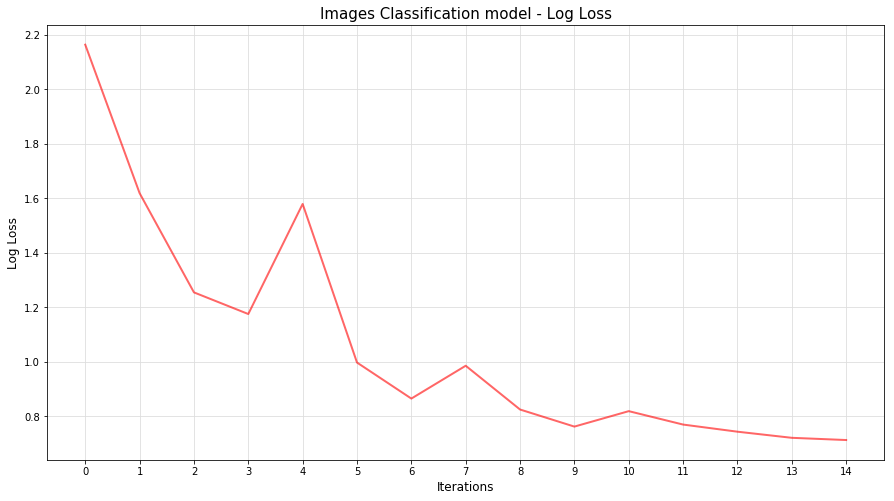

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
plt.plot(automlvisionmetrics['log_loss'], 'r-', lw = 2, alpha = .6)
plt.xlabel('Iterations', fontsize = 12)
plt.ylabel('Log Loss', fontsize = 12)
plt.title('Images Classification model - Log Loss', fontsize = 15)
plt.grid( color='#DDDDDD', linewidth = 0.8)
plt.xticks(np.arange(0, 15, 1))
plt.savefig('automl1_logloss.png')
plt.show()

In [55]:
# You can view the jpg file in the experiment
experiment

Name,Workspace,Report Page,Docs Page
AutoMLImages-MusicGenreClassification,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


## Let's improve using additionals models & hyperparameter tuning

### Hyperparameter sweeping for your AutoML models for computer vision tasks

When using AutoML for Images, you can perform a hyperparameter sweep over a defined parameter space, to find the optimal model. In this example, we sweep over the hyperparameters for each algorithm, **choosing from a range of values for learning_rate, optimizer, lr_scheduler, etc, to generate a model with the optimal 'accuracy'.** If hyperparameter values are not specified, then default values are used for the specified algorithm.

We use **Random Sampling to pick samples from this parameter space and try a total of 10 iterations** with these different samples, running 4 iterations at a time on our compute target, which has been previously set up using 4 nodes. Please note that the more parameters the space has, the more iterations you need to find optimal models.

We also leverage the **Bandit early termination policy** that terminates poor performing configs (those that are not within 20% slack of the best perfroming config), thus significantly saving compute resources.

Supported Algorithms
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#supported-model-algorithms

In [56]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import BanditPolicy, RandomParameterSampling
from azureml.train.hyperdrive import choice, uniform

parameter_space = {
    "learning_rate": uniform(0.001, 0.01),
    "model": choice(
        {
            "model_name": choice("vitb16r224", "vits16r224"),
            "number_of_epochs": choice(15, 30),
        },
        {
            "model_name": choice("seresnext", "resnest50"),
            "layers_to_freeze": choice(0, 1, 2),
        },
    ),
}

tuning_settings = {
    "iterations": 10,
    "max_concurrent_iterations": 5,
    "hyperparameter_sampling": RandomParameterSampling(parameter_space),
    "early_termination_policy": BanditPolicy(
        evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
    ),
}

automl_image_config = AutoMLImageConfig(
    task=ImageTask.IMAGE_CLASSIFICATION,
    compute_target=compute_target,
    training_data=training_dataset,
    validation_data=validation_dataset,
    **tuning_settings,
)

In [58]:
automl_image_run = experiment.submit(automl_image_config)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
AutoMLImages-MusicGenreClassification,AutoML_0e854488-29d1-48b6-b704-cc925f36322f,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [59]:
automl_image_run.wait_for_completion(wait_post_processing=True)

{'runId': 'AutoML_0e854488-29d1-48b6-b704-cc925f36322f',
 'target': 'AutoML-GPU',
 'status': 'Completed',
 'startTimeUtc': '2022-03-21T09:50:41.457633Z',
 'endTimeUtc': '2022-03-21T10:31:59.66018Z',
 'services': {},
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'AutoML-GPU',
  'AMLSettingsJsonString': '{"path":null,"name":"AutoMLImages-MusicGenreClassification","subscription_id":"70b8f39e-8863-49f7-b6ba-34a80799550c","resource_group":"azuremlvision-rg","workspace_name":"azuremlvision","region":"westeurope","compute_target":"AutoML-GPU","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":true,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1,"primary_metric":"

> When doing a hyperparameter sweep, **it can be useful to visualize the different configurations that were tried using the HyperDrive UI**. <br><br>You can navigate to this UI by going to the **'Child runs' tab in the UI of the main automl_image_run** from above, which is the HyperDrive parent run. Then you can go into the 'Child runs' tab of this one.

In [60]:
experiment

Name,Workspace,Report Page,Docs Page
AutoMLImages-MusicGenreClassification,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


### You will see all the AutoML runs from the Child runs section. 
The **model column** will display detailled information about each model.<br>

> You can find all the artefacts from the output+logs section of Azure ML

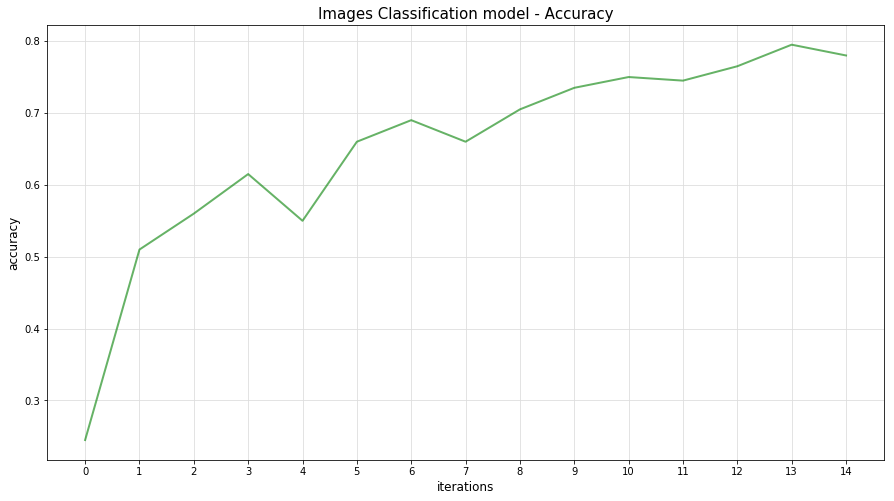

In [61]:
# Let's plot the accuracy metric for the CV model, save the graph to a jpg file and log it to the Azure ML experiment
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
plt.plot(automlvisionmetrics['accuracy'], 'g-', lw=2, alpha=.6)
plt.xlabel('iterations', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.title('Images Classification model - Accuracy', fontsize=15)
plt.grid(color='#DDDDDD', linewidth = 0.8)
plt.xticks(np.arange(0, 15, 1))
plt.savefig('automl2_vitb16r224.jpg', dpi=150) # Saving image in a jpg file
automl_image_run.log_image(name='automl2_vitb16r224.jpg', plot=plt) # Logging the graph into the Azure ML experiment

plt.show()

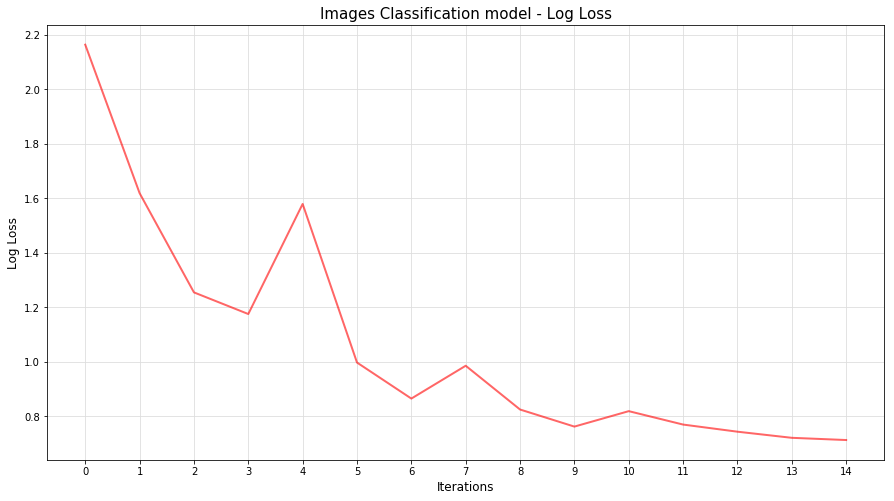

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
plt.plot(automlvisionmetrics['log_loss'], 'r-', lw = 2, alpha = .6)
plt.xlabel('Iterations', fontsize = 12)
plt.ylabel('Log Loss', fontsize = 12)
plt.title('Images Classification model - Log Loss', fontsize = 15)
plt.grid( color='#DDDDDD', linewidth = 0.8)
plt.xticks(np.arange(0, 15, 1))
plt.savefig('automl2_logloss.png')
plt.show()

In [63]:
# List of all the AutoML for Images metrics values
automlvisionmetrics = automl_image_run.get_metrics()
automlvisionmetrics

{'classification_report': {'class_name': ['blues',
   'classical',
   'country',
   'disco',
   'hiphop',
   'jazz',
   'metal',
   'pop',
   'reggae',
   'rock',
   'micro avg',
   'macro avg',
   'weighted avg'],
  'precision': [0.78947,
   0.90909,
   0.77778,
   0.75,
   0.77273,
   0.85714,
   0.94118,
   0.85,
   0.82353,
   0.7,
   0.815,
   0.81709,
   0.81709],
  'recall': [0.75,
   1.0,
   0.7,
   0.9,
   0.85,
   0.9,
   0.8,
   0.85,
   0.7,
   0.7,
   0.815,
   0.815,
   0.815],
  'f1-score': [0.76923,
   0.95238,
   0.73684,
   0.81818,
   0.80952,
   0.87805,
   0.86486,
   0.85,
   0.75676,
   0.7,
   0.815,
   0.81358,
   0.81358],
  'support': [20.0,
   20.0,
   20.0,
   20.0,
   20.0,
   20.0,
   20.0,
   20.0,
   20.0,
   20.0,
   200.0,
   200.0,
   200.0],
  'auc': [0.98,
   0.9975,
   0.95056,
   0.96917,
   0.9475,
   0.97556,
   0.99556,
   0.98778,
   0.96139,
   0.93611,
   0.97215,
   0.97011,
   0.97011],
  'average_precision': [0.8902,
   0.97289,
   0.717

## 8. Register the optimal CV model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [64]:
from azureml.core import Run
hyperdrive_run = Run(experiment=experiment, run_id=automl_image_run.id + '_HD')
hyperdrive_run

Experiment,Id,Type,Status,Details Page,Docs Page
AutoMLImages-MusicGenreClassification,AutoML_0e854488-29d1-48b6-b704-cc925f36322f_HD,hyperdrive,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [65]:
# Defining tags for the custom vision model
cvmodel_tags={"Data": "Images", 
              "Context" : "Music Genre Classification",
              "Task" : "Best AutoML Images",
              "Framework" : "AzureML AutoML for Images",
              "AutoML Metric" : "Accuracy"}

In [66]:
# Register the best model from the AutoML Vision run in ONNX file format
best_child_run = automl_image_run.get_best_child()

model = best_child_run.register_model(model_name = 'MusicGenreONNX',
                                      model_path = 'train_artifacts/model.onnx',
                                      description = 'Music Genre Classification',
                                      tags = cvmodel_tags)

In [69]:
#os.mkdir('model')

In [68]:
# We can download the CV model ONNX
model.download(target_dir = 'model', exist_ok=True, exists_ok=None)

'model/model.onnx'

In [70]:
# Checking the downloaded ONNX model file
filedir('model/model.onnx')

model/model.onnx | 2022-03-21 10:32:35 | 97.29 Mb


In [71]:
# Defining tags for the custom vision model
cvmodel_tags={"Data": "Images", 
              "Context" : "Music Genre Classification",
              "Task" : "Best AutoML Images",
              "Framework" : "AzureML AutoML for Images",
              "AutoML Metric" : "Accuracy"}

In [72]:
# Register the best model from the AutoML Vision run
best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties['model_name']

model = best_child_run.register_model(model_name = model_name,
                                      model_path='outputs/model.pt',
                                      description='Music Genre Classification',
                                      tags=cvmodel_tags)

In [73]:
# We can download the CV model
model.download(target_dir='model', exist_ok=True, exists_ok=None)

'model/model.pt'

In [74]:
# Checking the downloaded .pt model file
filedir('model/model.pt')

model/model.pt | 2022-03-21 10:32:48 | 195.24 Mb


### Model informations from the Azure ML model repository

In [75]:
model

Model(workspace=Workspace.create(name='azuremlvision', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='azuremlvision-rg'), name=AutoML0e85448824, id=AutoML0e85448824:1, version=1, tags={'Data': 'Images', 'Context': 'Music Genre Classification', 'Task': 'Best AutoML Images', 'Framework': 'AzureML AutoML for Images', 'AutoML Metric': 'Accuracy'}, properties={})

In [76]:
model.id

'AutoML0e85448824:1'

In [77]:
model.name

'AutoML0e85448824'

In [78]:
model.version

1

In [79]:
model.tags

{'Data': 'Images',
 'Context': 'Music Genre Classification',
 'Task': 'Best AutoML Images',
 'Framework': 'AzureML AutoML for Images',
 'AutoML Metric': 'Accuracy'}

In [80]:
model.created_time

datetime.datetime(2022, 3, 21, 10, 32, 43, 129328, tzinfo=<isodate.tzinfo.Utc object at 0x7f603b70c8d0>)

## 9. Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. **You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)).**<br><br> ACI is the perfect option for testing deployments, while AKS is better suited for for high-scale, production usage. <br><br>
**In this tutorial, we will deploy the model as a web service in AKS.**
You will need to first create an AKS compute cluster, or use an existing AKS cluster. <br>
You can use either GPU or CPU VM SKUs for your deployment cluster

In [82]:
%%time
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your cluster
aks_name = "aks-cluster"

# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    # Provision AKS cluster with GPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_NC6", 
                                                        location="westeurope")
    # Create the cluster
    aks_target = ComputeTarget.create(workspace=ws, 
                                      name=aks_name, 
                                      provisioning_configuration=prov_config)
    aks_target.wait_for_completion(show_output=True)

Found existing compute target.
CPU times: user 16.9 ms, sys: 196 µs, total: 17.1 ms
Wall time: 120 ms


Next, you will need to define the inference configuration, that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config.  
You can then deploy the model as an AKS web service.

In [83]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AksWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

endpoint_name='automl-musicgenre' # Name of the deployed model

aks_tags={"Data": "Images Sounds", 
          "Topic" : "Music Genre Classificationy", 
          "Task" : "Image Classification",
          "Framework" : "AutoML Images best model", 
          "AKS" : "True"}

aks_description="Computer vision model to detect Sound Anomaly"


best_child_run.download_file('outputs/scoring_file_v_1_0_0.py', output_file_path='model/score.py')
environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script='model/score.py', environment=environment)

aks_config = AksWebservice.deploy_configuration(autoscale_enabled=True,                                                    
                                                cpu_cores=1,
                                                memory_gb=50,
                                                enable_app_insights=True,
                                                description=aks_description,
                                                tags=aks_tags)

In [84]:
# Checking the file we downloaded
filedir('model/score.py')

model/score.py | 2022-03-21 10:33:07 | 0.0 Mb


In [85]:
# Viewing the score.py file
with open(os.path.join('model/score.py'), 'r') as f:
    print(f.read())

# ---------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# ---------------------------------------------------------
import os
import tempfile
import logging

from azureml.contrib.services.aml_request import rawhttp
from azureml.automl.core.shared import logging_utilities
from azureml.contrib.services.aml_response import AMLResponse
from azureml.core.model import Model

from azureml.automl.dnn.vision.common.utils import _set_logging_parameters
from azureml.automl.dnn.vision.common.model_export_utils import load_model, run_inference
from azureml.automl.dnn.vision.common.logging_utils import get_logger

from azureml.automl.dnn.vision.classification.inference.score import _score_with_model

TASK_TYPE = 'image-classification'
logger = get_logger('azureml.automl.core.scoring_script_images')


def init():
    global model

    # Set up logging
    _set_logging_parameters(TASK_TYPE, {})

    model_path = Model.get_model_path(model

### Let's deploy the CV model into AKS

In [86]:
%%time
aks_service = Model.deploy(ws,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target,
                           name=endpoint_name,
                           overwrite=True)

aks_service.wait_for_deployment(show_output=True)

print("\nDone. Model is deployed. Ready to use!")
print("\nAKS service status=", aks_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-03-21 10:33:16+00:00 Creating Container Registry if not exists.
2022-03-21 10:33:16+00:00 Registering the environment.
2022-03-21 10:33:17+00:00 Use the existing image.
2022-03-21 10:33:19+00:00 Creating resources in AKS.
2022-03-21 10:33:20+00:00 Submitting deployment to compute.
2022-03-21 10:33:20+00:00 Checking the status of deployment automl-musicgenre..
2022-03-21 10:36:50+00:00 Checking the status of inference endpoint automl-musicgenre.
Succeeded
AKS service creation operation finished, operation "Succeeded"

Done. Model is deployed. Ready to use!

AKS service status= Healthy
CPU times: user 707 ms, sys: 147 ms, total: 853 ms
Wall time: 3min 42s


> Usually it takes 2 or 3 minutes to deploy. You can see the endpoint in Azure ML Studio

In [ ]:
#print("CV model endpoint:", aks_service.scoring_uri)
print("CV model endpoint properties:", aks_service.properties)
print("CV model endpoint tags:", aks_service.tags)

In [ ]:
# You can have access to the logs
#print(aks_service.get_logs())

## 11. Clean up ressources

In [89]:
#aks_service.delete()

In [90]:
compute_target.delete()

> End of this notebook. You can use the next notebook.